In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import tina
# print(os.environ['CUDA_VISIBLE_DEVICES'])
os.environ['CUDA_VISIBLE_DEVICES']='1'

from plb.cut.sample_utils import init_env
env, state = init_env()

[Tina] version 0.1.1
[Taichi] mode=release
[Taichi] preparing sandbox at /tmp/taichi-8ttqubu7
[Taichi] version 0.7.26, llvm 10.0.0, commit e37bdb5e, linux, python 3.8.5
[Tina] Taichi properties hacked
Setting pykeops dir to  /home/xingyu/.pykeops_cache/NVIDIA_GeForce_RTX_2080_Ti
[Taichi] Starting on arch=cuda
pimirives: num primitive: 2
Building primitive
action:
  dim: 3
  scale: (0.015, 0.015, 0.015)
collision_group: [0.0, 0.0, 0.0]
color: (0.7568, 0.6039, 0.4196)
friction: 0.0
h: (0.15, 0.15)
init_pos: (0.5, 0.3, 0.5)
init_rot: (1.0, 0.0, 0.0, 0.0)
lower_bound: (0.0, 0.0, 0.0)
prot: (1.0, 0.0, 0.0, 0.58)
shape: Knife
size: (0.025, 0.2, 0.06)
upper_bound: (1.0, 1.0, 1.0)
variations: None
Building primitive
action:
  dim: 0
  scale: ()
collision_group: [0.0, 0.0, 0.0]
color: (0.3, 0.3, 0.3)
friction: 0.9
h: (0.15, 0.15)
init_pos: (0.3, 0.3, 0.3)
init_rot: (1.0, 0.0, 0.0, 0.0)
lower_bound: (0.0, 0.0, 0.0)
prot: (1.0, 0.0, 0.0, 0.58)
shape: 
upper_bound: (1.0, 1.0, 1.0)
variations: None

(512, 512, 4)


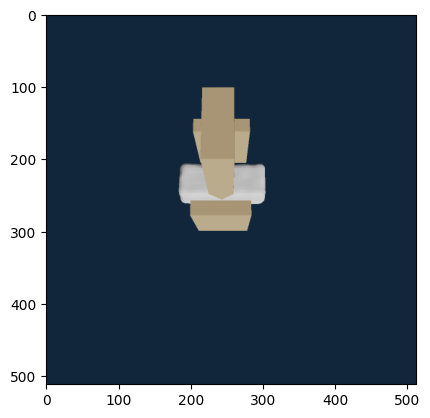

In [3]:
import matplotlib.pyplot as plt
img = env.render('rgb', img_size=512)
print(img.shape)
plt.imshow(img[:, :, :3])
plt.show()

In [4]:
from plb.cut.sample_utils import cut
from plb.cut.sample_utils import animate
env.set_state(**state)
images = list(cut(env, state, 0, filename='array', slide=True))
animate(images, 'xx.webm')


animating xx.webm
Moviepy - Building video xx.webm.
Moviepy - Writing video xx.webm



Moviepy - Done !
Moviepy - video ready xx.webm


In [5]:
import numpy as np
import copy

def cut(state, cut_loc, slide_a, slide_b):
    ns = copy.deepcopy(state)
    flag = ns['state'][0][:, 0] <= cut_loc
    ns['state'][0][flag, 0] -= slide_a
    ns['state'][0][np.logical_not(flag), 0] += slide_b
    return ns, flag

def move_cluster(state, flag, dx, dz, dy=0):
    # need to move forward..
    new_state = copy.deepcopy(state)
    mean = new_state['state'][0][flag].mean(axis=0)
    new_state['state'][0][flag] += np.array([dx, mean[1] + dy, dz]) - mean
    return new_state

[0.025 0.2   0.06 ]


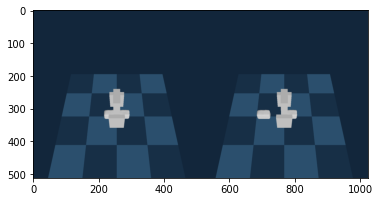

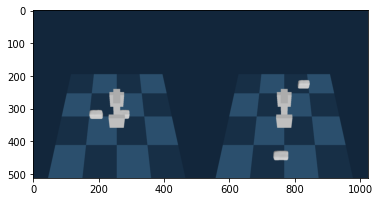

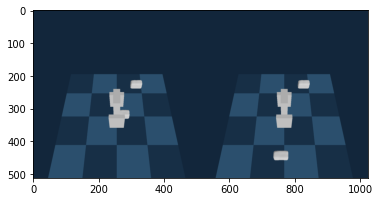

In [6]:
#env.renderer.update_camera((0.5, 0.1, 0.6), 1.0, -0.75, 0.75)
env.set_state(state)
"""
env.primitives[0].set_state(0, np.array([0.5, 0.35, 0.5, 1., 0., 0., 0.]))
env.primitives[1].set_state(0, np.array([0.5, 0.2, 0.5, 0.707, 0., 0.707, 0., 0.2]))
env.primitives[0].box.size[None] = (0.025, 0.2, 0.06)
state = env.get_state()
"""
print(env.primitives[0].box.size)

def generate(state):
    # sample two which are far away ..
    def rand(a, b):
        return np.random.random() * (b-a) + a

    state = copy.deepcopy(state)
    width = np.array([rand(0.2, 0.24), 0.08, rand(0.04, 0.08)])
    state['state'][0] = (np.random.random((len(state['state'][0]), 3)) * 2 - 1) * (0.5 * width) + np.array([0.5, 0.0669, 0.5])

    trajs = []
    da = db = 0.
    if np.random.randint(2):
        da = rand(0.1, 0.13)
    else:
        db = rand(0.1, 0.13)
    #cut = (np.random.random() * 2 - 1) * 0.75
    cut_loc = rand(0.48, 0.52)
    cutted, flag = cut(state, cut_loc, da, db)

    def sample_target():
        # make sure that it is moved away ..
        y = rand(0.3, 0.35) * (np.random.randint(2)*2 - 1) + 0.5
        x = rand(0.3, 0.7)
        return (x, y)

    trajs.append([state, cutted])

    while True:
        a = sample_target()
        b = sample_target()
        if np.linalg.norm(np.array(a) - np.array(b)) >= 0.3:
            break

    move1 = move_cluster(cutted, flag, *a)
    move2 = move_cluster(move1, np.logical_not(flag), *b)
    trajs.append([cutted, move2])
    trajs.append([move1, move2])
    return trajs

import numpy as np
import matplotlib.pyplot as plt

def visualize_traj(trajs):
    for sample in trajs:
        a, b = sample[:2]
        env.set_state(**a)
        img = env.render('rgb', img_size=512)
        env.set_state(**b)
        img2 = env.render('rgb', img_size=512)
        plt.imshow(np.concatenate((img, img2), 1)[..., :3])
        plt.show()

traj = generate(state)
visualize_traj(traj)

In [7]:
!pwd

/home/hza/PlasticineLab/plb/cut


In [8]:
import torch
for idx, i in enumerate(traj):
    torch.save(traj[idx], f'sampled{idx}.pkl')

In [9]:
import tqdm
os.makedirs('dataset3', exist_ok=True)
for idx2 in tqdm.trange(1000):
    traj = generate(state)
    for idx, i in enumerate(traj):
        torch.save(traj[idx], f'dataset3/traj{idx2:04d}_{idx}.pkl')


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 34.30it/s]


In [30]:
os.makedirs('data', exist_ok=True)
for i in range(4):
    os.makedirs(f'data/{i}', exist_ok=True)
    for j in range(i*70, (i+1)*70):
        traj = generate(state)
        for idx, k in enumerate(traj):
            torch.save(k, f'data/{i}/traj{j:04d}_{idx}.pkl')

In [16]:
raise NotImplementedError

a = torch.load('dataset3/traj0002_0.pkl')[0]
b = torch.load('dataset3/traj0002_0.pkl')[1]
torch.save([a, b], 'test.pkl')
print(a, b)

a = torch.load('dataset3/traj0002_0.pkl')[0]
b = torch.load('dataset3/traj0002_1.pkl')[1]
torch.save([a, b], 'test2.pkl')

{'state': [array([[0.5688541 , 0.03029123, 0.50746357],
       [0.52823332, 0.10656807, 0.48642678],
       [0.43519163, 0.04909143, 0.47352499],
       ...,
       [0.58068649, 0.06235912, 0.51481125],
       [0.50605258, 0.1015523 , 0.48333081],
       [0.39538474, 0.06989828, 0.48827778]]), array([[-0.00337464,  0.01843241, -0.00309275],
       [-0.00634152,  0.01579595, -0.00241307],
       [ 0.00410665,  0.02268436, -0.0020534 ],
       ...,
       [ 0.00140159,  0.02184484, -0.00352883],
       [-0.01121698,  0.01353134, -0.0014822 ],
       [-0.0044026 ,  0.01329166, -0.00369247]]), array([[[ 1.00102603e+00, -2.94379820e-03, -7.68423872e-03],
        [ 4.39149374e-03,  1.00122833e+00,  6.94103725e-03],
        [ 8.15120060e-03,  1.08960616e-04,  9.97232556e-01]],

       [[ 1.00334883e+00, -5.80076175e-03, -7.05649937e-03],
        [ 2.25213286e-03,  1.00475502e+00,  1.89252142e-02],
        [ 9.56470612e-03, -3.09458654e-02,  1.00784469e+00]],

       [[ 9.94446218e-01,  8.1364

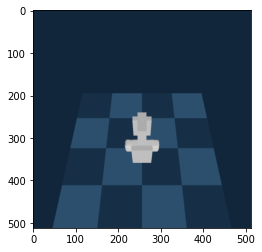

In [17]:
env.set_state(a)
img = env.render('rgb', img_size=512)
plt.imshow(img[:,:,:3])

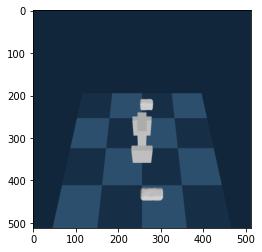

In [18]:
env.set_state(b)
img = env.render('rgb', img_size=512)
plt.imshow(img[:,:,:3])

In [26]:
a = torch.load('sampled9/traj0000_2_1.pkl')
b = torch.load('dataset3/traj0000_1.pkl')[1]
torch.save([a['initial_state'], b], 'test3.pkl')